In [40]:
import pandas as pd
from glob import glob
import os
import seaborn as sns
import re
from matplotlib import pyplot as plt

In [41]:
INCLUDE_SWIFT_LONG_LIBS = True

In [42]:
fastqc_results = glob("01_data_qc/QualityControl/*_001_fastqc/fastqc_data.txt")

In [43]:
def get_fastqc_data(path):
    name, suffixes = os.path.basename(os.path.dirname(path)).split("_", maxsplit=1)
    if 'Swift-long' in name:
        ide, _, _, conc, repl = name.split("-")
        kit = "Swiftlong"
        if not INCLUDE_SWIFT_LONG_LIBS:
            return []
    else:
        ide, kit, conc, repl = name.split("-")
    read = int(re.search(r"_R([12])_", suffixes).group(1))
    row_const = {'Kit': kit, 'Conc': conc, 'Replicate': repl, 'Read': read}
    section = 0
    rows = []
    with open(path) as f:
        for line in f:
            if section == 0:
                if line.startswith(">>Per base sequence content"):
                    section = 1
            elif section == 1:
                section += 1
            else:
                if line.startswith(">>END_MODULE"):
                    return rows
                else:
                    parts = line.strip().split()
                    if "-" in parts[0]:
                        pos, end = [int(x) for x in parts[0].split("-")]
                    else:
                        pos = end = int(parts[0])
                    for nucleotide, percent in zip("GATC", parts[1:]):
                        row = {"Pos": pos, "end": end, "Nucleotide": nucleotide, "Percent": float(percent)}
                        row.update(row_const)
                        rows.append(row)
    return []
                
            

In [44]:
df = pd.DataFrame([k for ks in map(get_fastqc_data, fastqc_results) for k in ks])
df.Conc = pd.Categorical(df.Conc, categories=['10ng', '100ng'])
if INCLUDE_SWIFT_LONG_LIBS:
    df.Kit = pd.Categorical(df.Kit, categories=['Kapa', 'NEB', 'Nextera', 'Quanta', 'Swift2S', 'Swiftlong'])
else:
    df.Kit = pd.Categorical(df.Kit, categories=['Kapa', 'NEB', 'Nextera', 'Quanta', 'Swift2S'])

In [45]:
df.head()

,Conc,Kit,Nucleotide,Percent,Pos,Read,Replicate,end
0,100ng,Quanta,G,26.803661,1,2,2,1
1,100ng,Quanta,A,22.136046,1,2,2,1
2,100ng,Quanta,T,20.739674,1,2,2,1
3,100ng,Quanta,C,30.320619,1,2,2,1
4,100ng,Quanta,G,19.324233,2,2,2,2


# Utility function

In [46]:
def savefig(name, main=True):
    if main:
        if INCLUDE_SWIFT_LONG_LIBS:
            plt.savefig('plots-main-withLong/{}'.format(name))
        else:
            plt.savefig('plots-main/{}'.format(name))
    else:
        if INCLUDE_SWIFT_LONG_LIBS:
            plt.savefig('plots-suppl-withLong/{}'.format(name))
        else:
            plt.savefig('plots-suppl/{}'.format(name))

## All kits combined

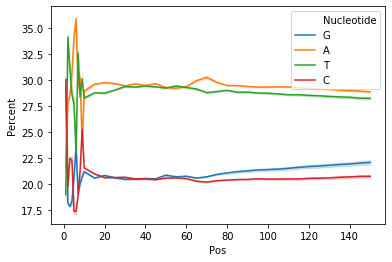

In [47]:
sns.lineplot(data=df, x='Pos', y='Percent', hue='Nucleotide')

## Read 1

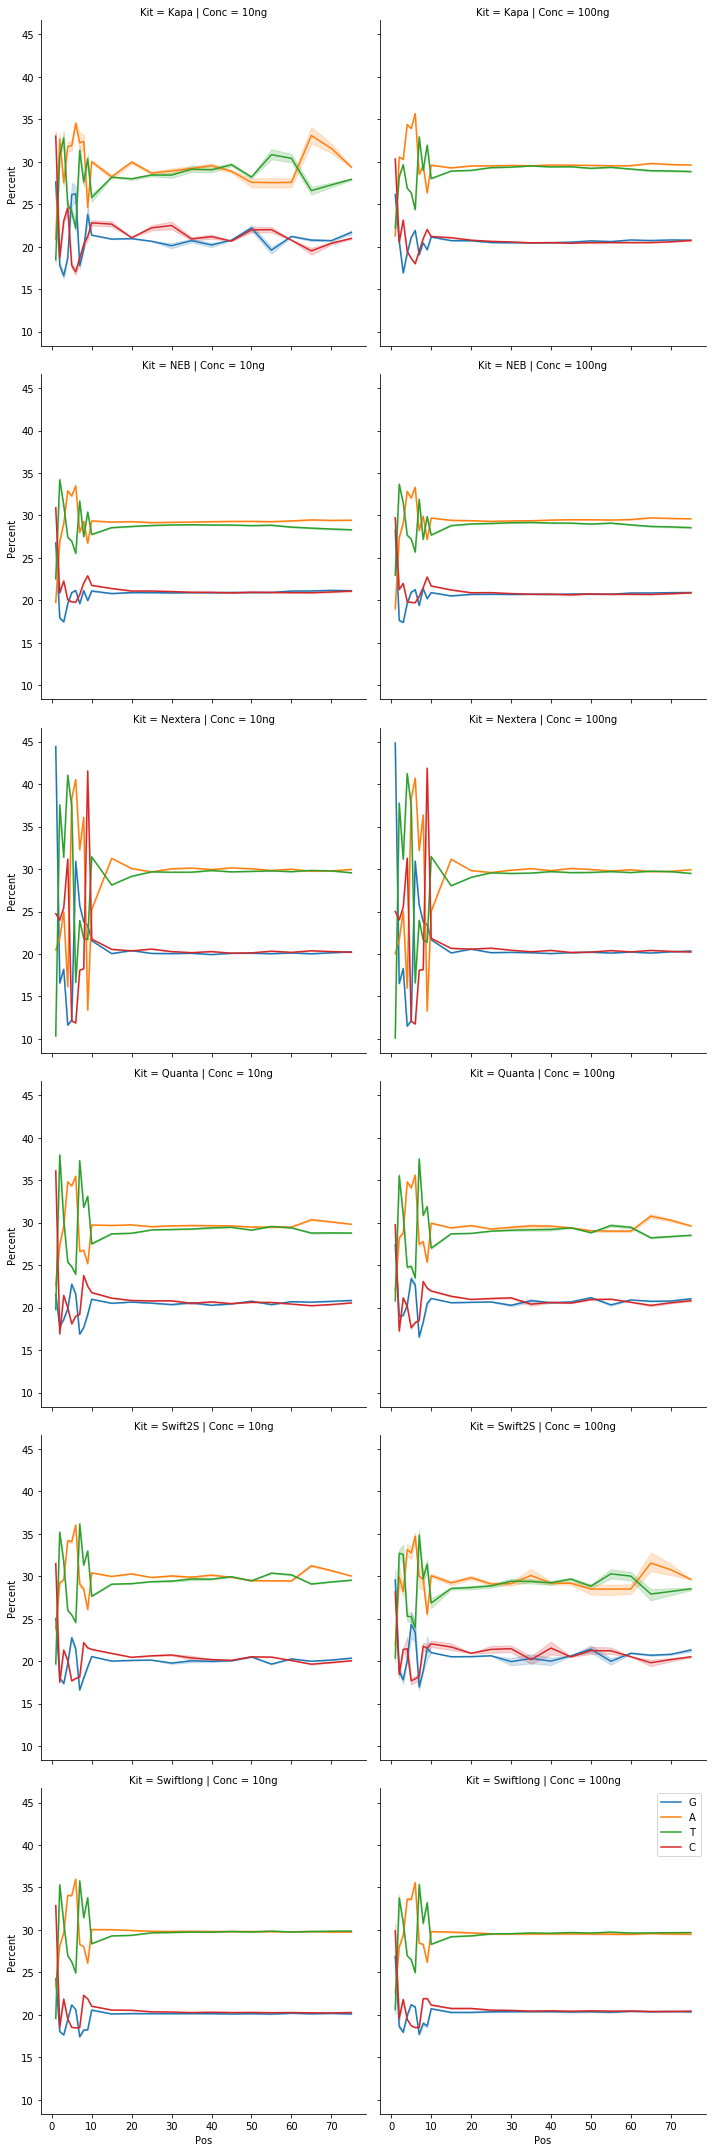

In [48]:
g = sns.FacetGrid(df[(df.Pos<80)&(df.Read==1)], col="Conc", row="Kit", hue='Nucleotide', height=5)
g.map(sns.lineplot, 'Pos', 'Percent')
plt.legend()
savefig('nucleotide_content_r1.pdf', False)

## Read 2

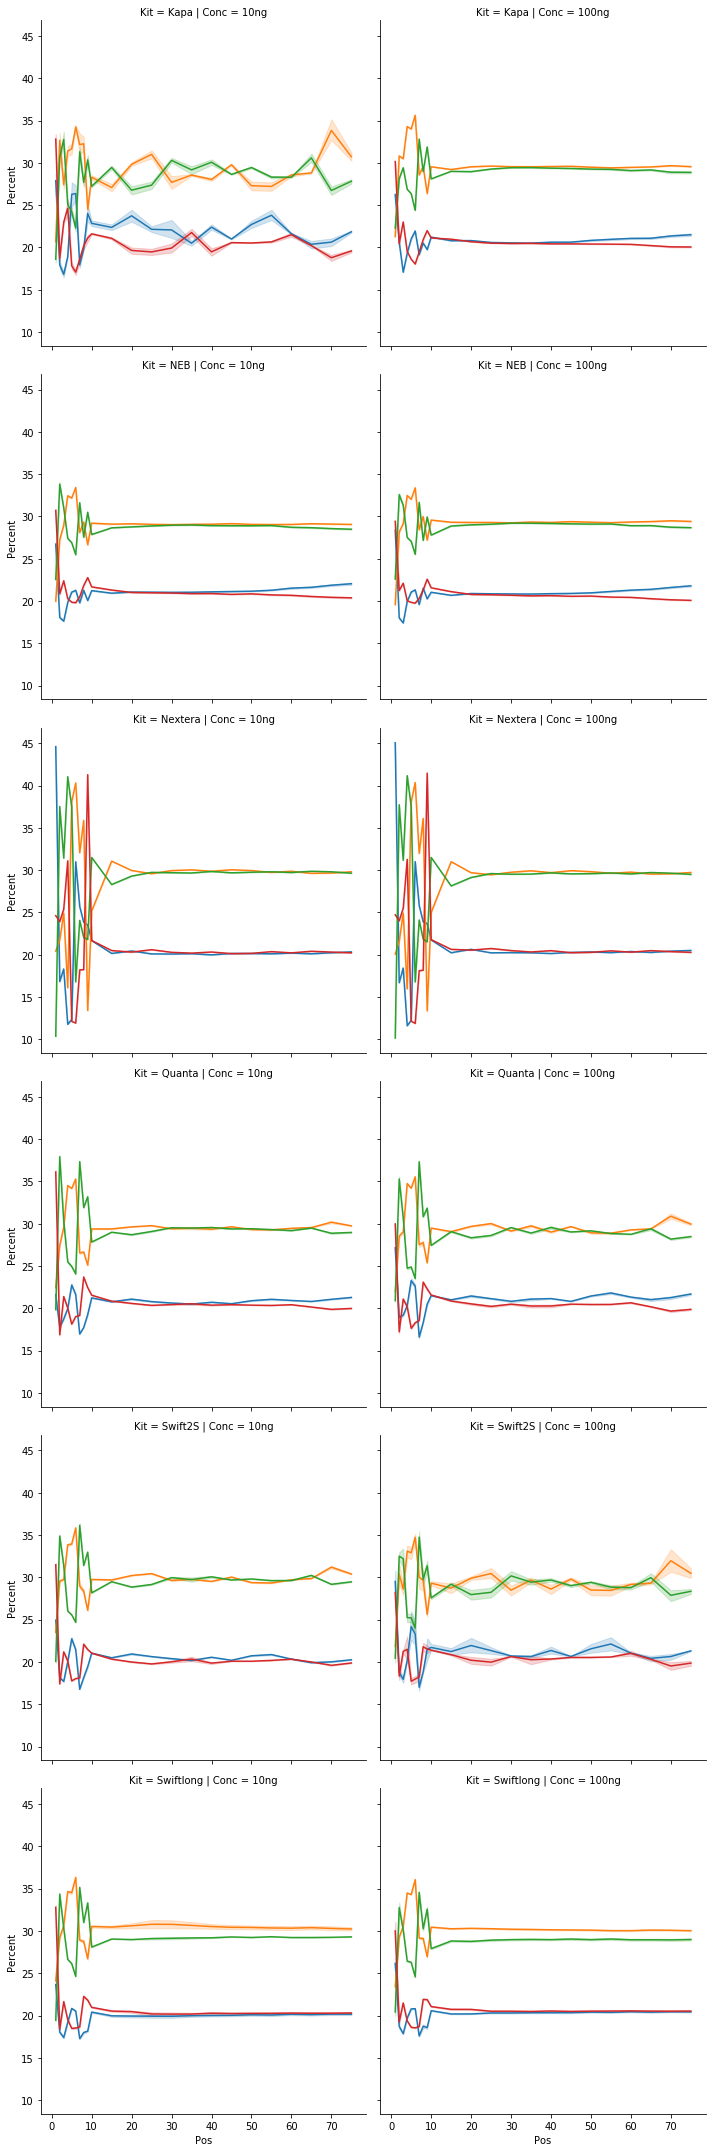

In [49]:
g = sns.FacetGrid(df[(df.Pos<80)&(df.Read==2)], col="Conc", row="Kit", hue='Nucleotide', height=5)
g.map(sns.lineplot, 'Pos', 'Percent')
savefig('nucleotide_content_r2.pdf', False)

# All in one plot

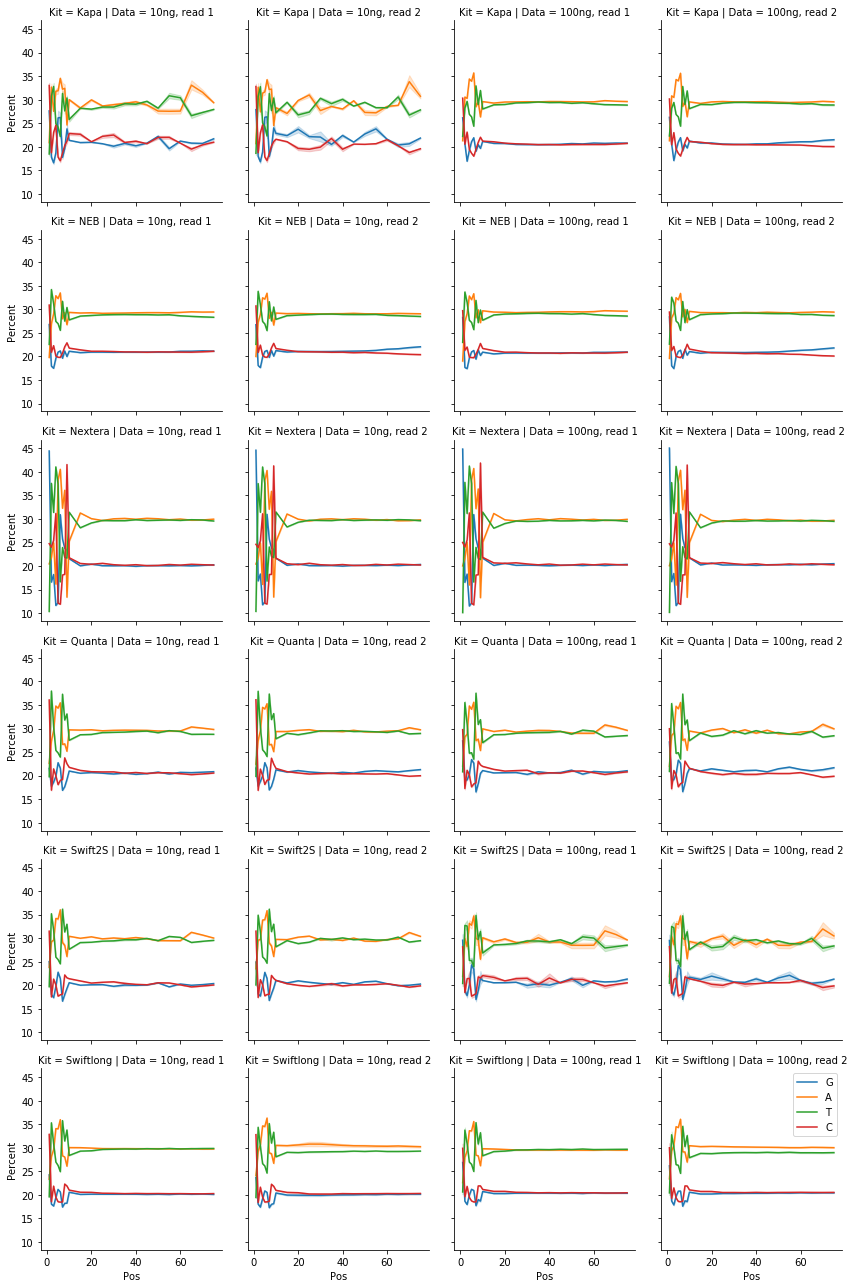

In [50]:
df['Data'] = pd.Categorical(
    df.Conc.astype(str) + ", read " + df.Read.astype(str),
    categories=['10ng, read 1', '10ng, read 2', '100ng, read 1', '100ng, read 2']
)
g = sns.FacetGrid(df[(df.Pos<80)], col="Data", row="Kit", hue='Nucleotide', height=3)
g.map(sns.lineplot, 'Pos', 'Percent')
plt.legend()
savefig('nucleotide_content_all.pdf')